In [1]:
# script_hang indefinitely at points_to_convex_hull_volume_mask

import numpy as np
import stackview
from vedo import Points, ConvexHull, Volume


def points_to_convex_hull_volume_mask(points, volume_shape_zyx, dilation_radius=3) -> Volume:
    """
    Converts a set of 3D points to a binary volume mask of the inner part of the embryo using a convex hull.

    This function takes a set of 3D points and a volume shape, constructs a convex hull from the points,
    binarizes the convex hull into a volume mask, and then erodes/dilates the mask. 

    Args:
        points (numpy.ndarray): A numpy array of shape (N, 3) representing the 3D points in ZYX order.
        volume_shape_zyx (tuple): A tuple (z, y, x) representing the shape of the volume.
        dilation_radius (int): The radius of the dilation applied to the volume mask.  This expands the mask
            outwards, useful for ensuring complete coverage of the structure represented by the points.

    Returns:
        vedo.Volume: A vedo.Volume object representing the binary volume mask.  The mask has values of 255 inside
            the convex hull and 0 outside.
    """
    points_raw = points[:, [2, 1, 0]]
    pts = Points(points_raw)
    print("Creating convex hull from points")
    hull = ConvexHull(pts)

    vol_shape_xyz = volume_shape_zyx[::-1]
    print("Binarizing convex hull into volume mask")
    vol_mask = hull.binarize(values=(255,0),dims=vol_shape_xyz,spacing=[1,1,1], origin=(0,0,0))
    if dilation_radius > 0:
        print(f"Dilating with radius of {dilation_radius}")
        modified = vol_mask.clone().dilate(neighbours=(dilation_radius,dilation_radius,dilation_radius))
    else:
        erosion_radius = abs(dilation_radius)
        print(f"Eroding with erosion radius of {erosion_radius}")
        modified = vol_mask.clone().erode(neighbours=(erosion_radius,erosion_radius,erosion_radius))
    return modified

down_cropped = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/down_cropped_tp_767.npy")
print(down_cropped.shape)
points = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/tp_767_surface_points.npy") 
print(points[0,:,:])
# mod = points_to_convex_hull_volume_mask(points, volume_shape_zyx=down_cropped.shape, dilation_radius=3)

(146, 298, 621)
[ 1 22 46]


In [5]:
stackview.slice(down_cropped, continuous_update=True)

In [6]:
from wbns import substract_background

only_structures = substract_background(down_cropped, 4, 1)

In [7]:
stackview.slice(only_structures, continuous_update=True)

In [9]:
# Otsu is clearly failing hard, and whole image is 1 value

from skimage import filters
from scipy import ndimage as cpu_ndimage


substracted_bkg = only_structures
th = filters.threshold_otsu(substracted_bkg)
mask = substracted_bkg >= th

structuring_element = np.ones((3,3,3))
eroded_mask = cpu_ndimage.binary_erosion(mask, structure=structuring_element).astype(mask.dtype)  # Keep original datatype
# Zerroing out the border to remove artifacts that wbns generates
zero_y = int(eroded_mask.shape[1] * (1.15 - 1) / 2) 
zero_x = int(eroded_mask.shape[2] * (1.15 - 1) / 2)
eroded_mask[:,-zero_y:,:] = False
eroded_mask[:,:zero_y,:] = False
eroded_mask[:,:,-zero_x:] = False
eroded_mask[:,:,:zero_x] = False
stackview.slice(mask, continuous_update=True)

In [16]:
substracted_bkg = only_structures
th = filters.threshold_mean(substracted_bkg)
mask = substracted_bkg >= th
stackview.slice(mask, continuous_update=True)

In [2]:
points.shape

(23110952, 3)

In [17]:
import numpy as np
points_766 = np.load("/scratch/artemiy/test_data_for_serosa_peeling/peeling_debug/script_hang_at__points_to_convex_hull_volume_mask/tp_766_surface_points.npy")
points_766.shape

(92905, 3)

In [19]:
from scipy.spatial import ConvexHull
import time 

start_time = time.perf_counter()
hull = ConvexHull(points)
end_time = time.perf_counter()

execution_time = end_time - start_time
print(f"Function execution time: {execution_time:.4f} seconds")


Function execution time: 3.1477 seconds


Pruning points in a surface mask

In [48]:
import numpy as np
from multiprocessing import Pool

def prune_slice_cpu(slice_2d, radius=4):
    """
    Prune a 2D boolean slice so that within each circular neighborhood of radius `radius`
    only the True pixel that is furthest from the mid_point is retained.

    Parameters:
      slice_2d : 2D numpy array (bool)
          Input slice.
      radius : int, optional
          Radius of the circular neighborhood (default is 4).

    Returns:
      pruned : 2D numpy array (bool)
          The pruned slice.
    """
    H, W = slice_2d.shape
    # Define the mid_point as the right middle pixel (row=H//2, col=W-1)
    mid_point = (H // 2, W - 1)
    
    # Find all indices where the pixel is True
    true_indices = np.argwhere(slice_2d)
    if len(true_indices) == 0:
        return slice_2d.copy()
    
    # Compute squared Euclidean distances from each true pixel to the mid_point.
    distances = (true_indices[:, 0] - mid_point[0])**2 + (true_indices[:, 1] - mid_point[1])**2
    
    # Process pixels in order of descending distance (furthest first)
    order = np.argsort(-distances)
    sorted_indices = true_indices[order]
    
    # Create an output array and a suppression mask (both same shape as slice_2d)
    pruned = np.zeros_like(slice_2d, dtype=bool)
    suppressed = np.zeros_like(slice_2d, dtype=bool)
    
    # Precompute offsets for a disk-shaped footprint (all offsets (dy,dx) such that distance<=radius)
    offsets = []
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if np.sqrt(dy**2 + dx**2) <= radius:
                offsets.append((dy, dx))
    
    # Greedy suppression: for each candidate pixel, if it has not been suppressed,
    # mark it as kept and then suppress all pixels in its neighborhood.
    for r, c in sorted_indices:
        if suppressed[r, c]:
            continue
        pruned[r, c] = True
        # Suppress all pixels in the disk neighborhood around (r, c)
        for dy, dx in offsets:
            rr = r + dy
            cc = c + dx
            if 0 <= rr < H and 0 <= cc < W:
                suppressed[rr, cc] = True
                
    return pruned

def prune_volume_cpu(volume, radius=4, num_processes=None):
    """
    Prune a 3D boolean volume along the first axis using CPU multiprocessing.
    Each 2D slice is pruned independently.

    Parameters:
      volume : 3D numpy array (bool)
          Input volume with shape (slices, height, width).
      radius : int, optional
          Radius for the neighborhood (default is 4).
      num_processes : int, optional
          Number of processes to use (defaults to the number of CPU cores).

    Returns:
      pruned_volume : 3D numpy array (bool)
          The volume after pruning.
    """
    slices = [volume[i] for i in range(volume.shape[0])]
    with Pool(processes=num_processes) as pool:
        results = pool.starmap(prune_slice_cpu, [(s, radius) for s in slices])
    return np.stack(results, axis=0)

def prune_slice_gpu(slice_2d, radius=4):
    """
    GPU-accelerated pruning for a single 2D slice using CuPy.
    This implementation computes a score for each pixel (its squared distance from mid_point)
    and uses a maximum filter with a disk-shaped footprint to approximate non-maximum suppression.
    Note: In regions with tied maximum scores, more than one pixel may be retained.

    Parameters:
      slice_2d : 2D numpy array (bool)
          Input slice.
      radius : int, optional
          Radius for the neighborhood (default is 4).

    Returns:
      pruned : 2D numpy array (bool)
          The pruned slice (transferred back to CPU memory).
    """
    try:
        import cupy as cp
        import cupyx.scipy.ndimage as cndi
    except ImportError:
        raise ImportError("CuPy is not installed. Install CuPy to use GPU acceleration.")
    
    H, W = slice_2d.shape
    mid_point = (H // 2, W - 1)
    
    # Transfer the slice to the GPU
    slice_gpu = cp.array(slice_2d)
    # Create coordinate grids
    y, x = cp.indices(slice_gpu.shape)
    # Compute the score: for true pixels, use squared distance from mid_point; for false, set to -inf
    score = cp.where(slice_gpu, (y - mid_point[0])**2 + (x - mid_point[1])**2, -cp.inf)
    
    # Create a disk-shaped footprint
    y_off, x_off = cp.meshgrid(cp.arange(-radius, radius + 1), cp.arange(-radius, radius + 1), indexing='ij')
    footprint = cp.sqrt(y_off**2 + x_off**2) <= radius
    
    # Apply a maximum filter using the disk footprint
    local_max = cndi.maximum_filter(score, footprint=footprint)
    
    # Identify local maxima (approximate non-maximum suppression)
    local_maxima = (score == local_max) & (score != -cp.inf)
    
    # Transfer the result back to the CPU
    pruned = cp.asnumpy(local_maxima)
    return pruned

def prune_volume_gpu(volume, radius=4):
    """
    Prune a 3D boolean volume using GPU acceleration.
    Each 2D slice (along the first axis) is processed on the GPU.

    Parameters:
      volume : 3D numpy array (bool)
          Input volume with shape (slices, height, width).
      radius : int, optional
          Radius for the neighborhood (default is 4).

    Returns:
      pruned_volume : 3D numpy array (bool)
          The pruned volume.
    """
    pruned_slices = []
    for i in range(volume.shape[0]):
        pruned_slice = prune_slice_gpu(volume[i], radius)
        pruned_slices.append(pruned_slice)
    return np.stack(pruned_slices, axis=0)

/home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/stackview/_static_view.py:101: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
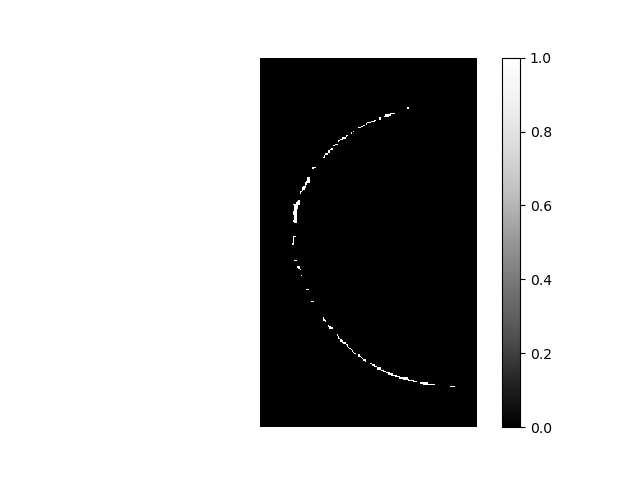
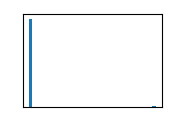

In [38]:
import tifffile as tiff
mask = tiff.imread("outs/tp_301_wbns_surface_voxels_true.tif")
mask = np.transpose(mask, (2,1,0))
stackview.insight(mask[244])

In [47]:
np.random.seed(42)
# Create a random 3D volume with 10 slices of 100x100 pixels; true pixels are sparse.
# volume = np.random.rand(100, 1000, 1000) > 0.98
volume = mask
print("Original true pixel counts per slice:")
# for i in range(100,volume.shape[0]-100):
#     print(f" Slice {i}: {np.sum(volume[i])} true pixels")

pruned_gpu = prune_volume_cpu(volume, radius=4)


Original true pixel counts per slice:


TypingError: [1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mNo implementation of function Function(<function zeros_like at 0x7fbc8c32cdc0>) found for signature:
 
 >>> zeros_like(array(bool, 2d, C), dtype=Function(<class 'bool'>))
 
There are 2 candidate implementations:
[1m     - Of which 2 did not match due to:
     Overload in function 'ol_np_zeros_like': File: numba/np/arrayobj.py: Line 4495.
       With argument(s): '(array(bool, 2d, C), dtype=Function(<class 'bool'>))':[0m
[1m      Rejected as the implementation raised a specific error:
        TypingError: Failed in nopython mode pipeline (step: nopython frontend)
      [1m[1m[1m[1mNo implementation of function Function(<built-in function empty_like>) found for signature:
       
       >>> empty_like(array(bool, 2d, C), dtype=Function(<class 'bool'>))
       
      There are 2 candidate implementations:
      [1m      - Of which 2 did not match due to:
            Overload in function 'ol_np_empty_like': File: numba/np/arrayobj.py: Line 4440.
              With argument(s): '(array(bool, 2d, C), dtype=Function(<class 'bool'>))':[0m
      [1m       Rejected as the implementation raised a specific error:
               TypingError: [1mCannot parse input types to function np.empty_like(array(bool, 2d, C), Function(<class 'bool'>))[0m[0m
        raised from /home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/np/arrayobj.py:4458
      [0m
      [0m[1mDuring: resolving callee type: Function(<built-in function empty_like>)[0m
      [0m[1mDuring: typing of call at /home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/np/arrayobj.py (4501)
      [0m
      [1m
      File "../../../mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/np/arrayobj.py", line 4501:[0m
      [1m    def impl(a, dtype=None):
      [1m        arr = np.empty_like(a, dtype=dtype)
      [0m        [1m^[0m[0m
      
      [0m[1mDuring: Pass nopython_type_inference[0m[0m
  raised from /home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/numba/core/typeinfer.py:1074
[0m
[0m[1mDuring: resolving callee type: Function(<function zeros_like at 0x7fbc8c32cdc0>)[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_1703107/2616119661.py (38)
[0m
[1m
File "../../../../../tmp/ipykernel_1703107/2616119661.py", line 38:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m[0m

/home/artemiy/mambaforge/envs/tubetracing/lib/python3.10/site-packages/stackview/_static_view.py:101: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  h, _ = np.histogram(self.obj, bins=num_bins)


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
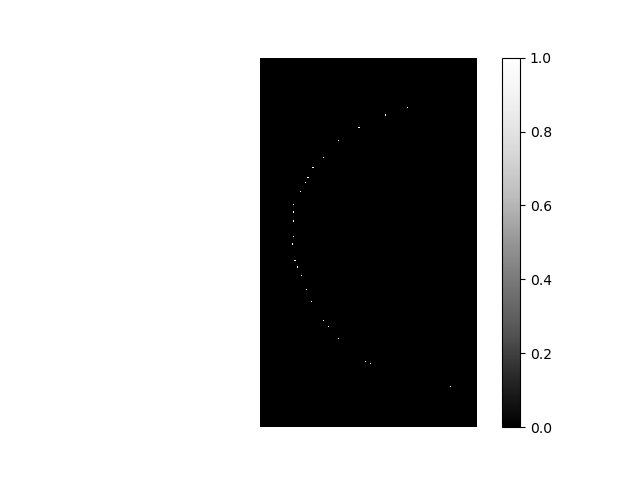
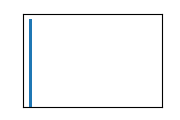

In [56]:
stackview.insight(pruned_gpu[244])

In [102]:
sparce_p = np.transpose(np.where(pruned_gpu))

In [103]:
hull = ConvexHull(sparce_p)

In [106]:
import numpy as np
import cupy as cp

def prune_volume(volume):
    """
    GPU accelerated pruning of voxels in a 3D volume.
    
    For each slice of the volume (along the first axis), the function splits the slice into
    non-overlapping 4x4 blocks. For each block, only one pixel with value True is kept:
    the one that is furthest from the mid-point of the slice, where the mid-point is defined as
    (x=width-1, y=height//2). All other True pixels in the block are set to False.
    
    Parameters:
        volume (np.ndarray): 3D numpy array with boolean values, shape (n_slices, height, width)
    
    Returns:
        pruned_volume (np.ndarray): 3D numpy array with pruned voxels.
    """
    # Transfer the volume to GPU memory.
    volume_cp = cp.asarray(volume)
    n_slices, height, width = volume_cp.shape

    # Define the block (tile) size.
    block_h, block_w = 4, 4

    # Determine how many blocks (non-overlapping) fit along each dimension.
    grid_x = (width + block_w - 1) // block_w
    grid_y = (height + block_h - 1) // block_h

    # Define the mid-point for the slice: rightmost x and center y.
    mid_y = height // 2
    mid_x = width // 2

    # CUDA kernel that processes a single 4x4 block.
    # It first finds the true pixel with the maximum squared distance to the mid-point,
    # then clears all other true pixels in that block.
    kernel_code = r'''
    extern "C" __global__
    void prune_block(bool* slice, int height, int width, int block_h, int block_w, int mid_y, int mid_x) {
        int block_idx_x = blockIdx.x;  // block index along width
        int block_idx_y = blockIdx.y;  // block index along height
        int start_y = block_idx_y * block_h;
        int start_x = block_idx_x * block_w;
    
        float max_dist = -1.0f;
        int max_r = -1, max_c = -1;
        
        // First pass: Identify the true pixel with the furthest distance from mid_point.
        for (int i = 0; i < block_h; i++) {
            int r = start_y + i;
            if (r >= height) break;
            for (int j = 0; j < block_w; j++) {
                int c = start_x + j;
                if (c >= width) break;
                int index = r * width + c;
                if (slice[index]) {
                    int dx = c - mid_x;
                    int dy = r - mid_y;
                    float dist = (float)(dx * dx + dy * dy);
                    if (dist > max_dist) {
                        max_dist = dist;
                        max_r = r;
                        max_c = c;
                    }
                }
            }
        }
        // Second pass: Clear all true pixels except the one with maximum distance.
        for (int i = 0; i < block_h; i++) {
            int r = start_y + i;
            if (r >= height) break;
            for (int j = 0; j < block_w; j++) {
                int c = start_x + j;
                if (c >= width) break;
                int index = r * width + c;
                if (slice[index] && !(r == max_r && c == max_c)) {
                    slice[index] = false;
                }
            }
        }
    }
    '''
    # Compile the kernel.
    module = cp.RawModule(code=kernel_code)
    prune_block = module.get_function("prune_block")

    # Process each slice independently.
    for s in range(n_slices):
        slice_cp = volume_cp[s]
        prune_block(
            (grid_x, grid_y),  # grid dimensions: one thread per 4x4 block
            (1, 1, 1),         # single-thread per block (the kernel uses loops)
            (slice_cp, np.int32(height), np.int32(width),
             np.int32(block_h), np.int32(block_w), np.int32(mid_y), np.int32(mid_x))
        )

    # Transfer the result back to CPU.
    return cp.asnumpy(volume_cp)

if __name__ == '__main__':
    # Example usage: Create a random 3D volume and prune it.
    # For demonstration, generate a small volume of shape (2, 8, 8)
    np.random.seed(0)
    # volume = mask
    # volume = (np.random.rand(170, 290, 635) > 0.9)
    volume = (np.random.rand(2, 8, 8) > 0.8)
    print("Original volume:")
    print(volume.astype(int))
    pruned = prune_volume(volume)
    print("Pruned volume:")
    print(pruned.astype(int))
    # stackview.insight(pruned[244])


Original volume:
[[[0 0 0 0 0 0 0 1]
  [1 0 0 0 0 1 0 0]
  [0 1 0 1 1 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 1 0 1 0 1 0]
  [1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 1]
  [0 0 0 0 0 1 0 1]
  [0 0 1 0 1 0 1 0]
  [0 0 1 0 0 0 0 0]]]
Pruned volume:
[[[0 0 0 0 0 0 0 1]
  [1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 1 0]
  [1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]]


In [92]:
# mask = np.transpose(mask, (2, 1, 0))
mask.dtype

dtype('bool')

In [90]:
stackview.slice(mask, continuous_update=True, zoom_factor=2)

In [100]:
stackview.slice(pruned, continuous_update=True, zoom_factor=2)

In [101]:
stackview.slice(volume, continuous_update=True, zoom_factor=2)

In [104]:
print(np.sum(mask))
print(np.sum(pruned))

98416
27849


In [136]:
import numpy as np
from numba import njit, prange

@njit(parallel=True, cache=True)
def prune_volume_cpu(volume, block_h=4, block_w=4):
    """
    CPU accelerated pruning of voxels in a 3D volume using Numba.
    
    For each slice in the 3D boolean volume (shape: [n_slices, height, width]), the function:
      - Computes the mid-point of the slice as (x=width//2, y=height//2).
      - Splits the slice into non-overlapping 4x4 blocks by default.
      - Within each block, finds the True pixel furthest from the mid-point (using squared Euclidean distance).
      - Prunes the block by setting all True pixels to False except the selected one.
    
    Parameters:
        volume (np.ndarray): 3D numpy array with boolean values.
        block_h (int): Height of each block.
        block_w (int): Width of each block.
        
    Returns:
        volume (np.ndarray): The modified volume with pruned voxels.
    """
    n_slices, height, width = volume.shape
    block_h, block_w = 4, 4
    # mid-point for each slice (same for all slices)
    mid_y = height // 2
    mid_x = width // 2

    # Compute the number of blocks along each dimension.
    grid_y = (height + block_h - 1) // block_h
    grid_x = (width + block_w - 1) // block_w

    # Process each slice in parallel.
    for s in prange(n_slices):
        for by in range(grid_y):
            for bx in range(grid_x):
                start_y = by * block_h
                start_x = bx * block_w
                max_dist = -1.0
                max_r = -1
                max_c = -1
                # First pass: Find the True pixel with the maximum distance.
                for i in range(block_h):
                    r = start_y + i
                    if r >= height:
                        break
                    for j in range(block_w):
                        c = start_x + j
                        if c >= width:
                            break
                        if volume[s, r, c]:
                            dx = c - mid_x
                            dy = r - mid_y
                            dist = dx * dx + dy * dy
                            if dist > max_dist:
                                max_dist = dist
                                max_r = r
                                max_c = c
                # Second pass: Clear all True pixels except the one with max distance.
                if max_r != -1:  # if at least one True pixel was found
                    for i in range(block_h):
                        r = start_y + i
                        if r >= height:
                            break
                        for j in range(block_w):
                            c = start_x + j
                            if c >= width:
                                break
                            if volume[s, r, c] and not (r == max_r and c == max_c):
                                volume[s, r, c] = False
    return volume

if __name__ == '__main__':
    # Example usage: create a small random volume of shape (2, 8, 8)
    np.random.seed(0)
    volume = (np.random.rand(170, 2900, 635) > 0.9)
    print("Original volume:")
    # print(volume.astype(np.int32))
    
    # Create a copy if you wish to preserve the original volume.
    # pruned = prune_volume_cpu(volume.copy())
    print("Pruned volume:")
    # print(pruned.astype(np.int32))


Original volume:
Pruned volume:


In [137]:
volume = (np.random.rand(170, 2900, 635) > 0.9)

In [139]:
pruned = prune_volume_cpu(mask.copy())

In [116]:
stackview.slice(pruned, continuous_update=True, zoom_factor=2)